In [1]:
import os
import numpy as np
import pandas as pd

In [4]:
feature_folder = "/raid/mengliang/gabmil/tcga-brca_features/"
pt_file = os.path.join(feature_folder, "pt_files/TCGA-3C-AALI-01Z-00-DX2.CF4496E0-AB52-4F3E-BDF5-C34833B91B7C.pt")

In [9]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [6]:
loaded_data = torch.load(pt_file, map_location=torch.device('cpu'))

print("Data type:", type(loaded_data))
print("Data shape:", loaded_data.shape)

/tmp/ipykernel_2260885/331797783.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(pt_file, map_location=torch.device('cpu'))


Data type: <class 'torch.Tensor'>
Data shape: torch.Size([80982, 1024])



--- 进行 PCA 降维 ---
PCA 降维后数据形状: (80982, 50)
PCA 降维耗时: 6.21 秒
PCA 解释的方差比例: 0.9589

--- 进行 t-SNE 可视化 ---


/home/mxz3935/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE 降维后数据形状: (80982, 2)
t-SNE 计算耗时: 411.44 秒

--- 绘制 t-SNE 散点图 ---


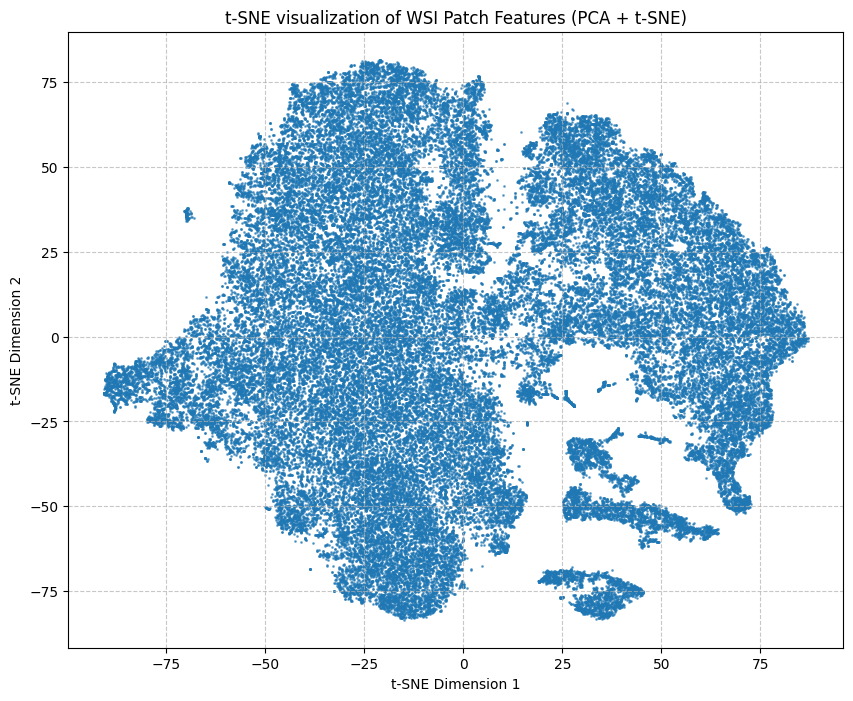

In [ ]:
# 将 PyTorch 张量转换为 NumPy 数组，因为 scikit-learn 通常使用 NumPy
features_np = loaded_data.cpu().numpy() # 如果是GPU上的张量，先转到CPU

# --- 2. PCA 降维 ---
print("\n--- 进行 PCA 降维 ---")
# 定义降维后的维度。通常降到 50-100 维是一个不错的选择，可以根据需要调整。
n_components_pca = 50
pca = PCA(n_components=n_components_pca, random_state=42)

start_time_pca = time.time()
features_pca = pca.fit_transform(features_np)
end_time_pca = time.time()

print(f"PCA 降维后数据形状: {features_pca.shape}")
print(f"PCA 降维耗时: {end_time_pca - start_time_pca:.2f} 秒")
print(f"PCA 解释的方差比例: {pca.explained_variance_ratio_.sum():.4f}") # 越高越好，表示保留的信息多

# --- 3. t-SNE 可视化 ---
print("\n--- 进行 t-SNE 可视化 ---")
# t-SNE 参数调整：
# n_components: 降维到的维度，通常是 2 或 3 用于可视化
# perplexity: 困惑度，通常在 5 到 50 之间。对于大型数据集，可以尝试更大的值（例如 50-100）。
#             它与局部和全局结构的平衡有关。
# n_iter: 迭代次数，通常 1000-5000。
# learning_rate: 学习率。
# init: 初始化方式，'pca' 通常比 'random' 更好，因为它可以加速收敛。
# random_state: 为了结果可复现。
tsne = TSNE(n_components=2, perplexity=50, n_iter=2000, learning_rate=200,
            init='pca', random_state=42, n_jobs=-1) # n_jobs=-1 使用所有可用CPU核心

start_time_tsne = time.time()
# 注意：对于非常大的数据集，t-SNE 可能仍然需要较长时间。
# 确保您的Python环境中有 openTSNE 或其他更快的t-SNE实现，如果 sklearn 的不够快。
# sklearn 的 TSNE 默认使用 Barnes-Hut 算法，但对于超大数据集仍可能慢。
tsne_results = tsne.fit_transform(features_pca)
end_time_tsne = time.time()

print(f"t-SNE 降维后数据形状: {tsne_results.shape}")
print(f"t-SNE 计算耗时: {end_time_tsne - start_time_tsne:.2f} 秒")

# --- 4. 可视化结果 ---
print("\n--- 绘制 t-SNE 散点图 ---")
plt.figure(figsize=(10, 8))
# 假设您没有标签信息，所以所有点都用同一种颜色
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=1, alpha=0.6) # s=1 减小点的大小，alpha 增加透明度
plt.title('t-SNE visualization of WSI Patch Features (PCA + t-SNE)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- 5. 如果有标签信息，可以这样可视化 ---
# 假设有一个与 features_tensor 对应长度的标签列表或 NumPy 数组
# 例如：labels = np.random.randint(0, 5, size=80982) # 模拟 5 个类别

# if 'labels' in locals(): # 检查labels变量是否存在
#     print("\n--- 绘制带标签的 t-SNE 散点图 ---")
#     plt.figure(figsize=(12, 10))
#     # 使用 seaborn 绘制，可以根据标签自动着色
#     sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1],
#                     hue=labels, # 使用 'labels' 进行颜色编码
#                     palette=sns.color_palette("hsv", len(np.unique(labels))), # 根据标签数量生成颜色
#                     legend="full",
#                     s=1, alpha=0.6)
#     plt.title('t-SNE visualization of WSI Patch Features (with Labels)')
#     plt.xlabel('t-SNE Dimension 1')
#     plt.ylabel('t-SNE Dimension 2')
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.show()


--- 进行数据采样 (采样比例: 10%) ---
原始样本数量: 80982
采样样本数量: 8098
采样后特征数据形状: (8098, 1024)

--- 进行 PCA 降维 ---
PCA 降维后数据形状: (8098, 50)
PCA 降维耗时: 2.47 秒
PCA 解释的方差比例: 0.9590

--- 进行 t-SNE 可视化 ---


/home/mxz3935/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE 降维后数据形状: (8098, 2)
t-SNE 计算耗时: 36.47 秒

--- 绘制 t-SNE 散点图 ---


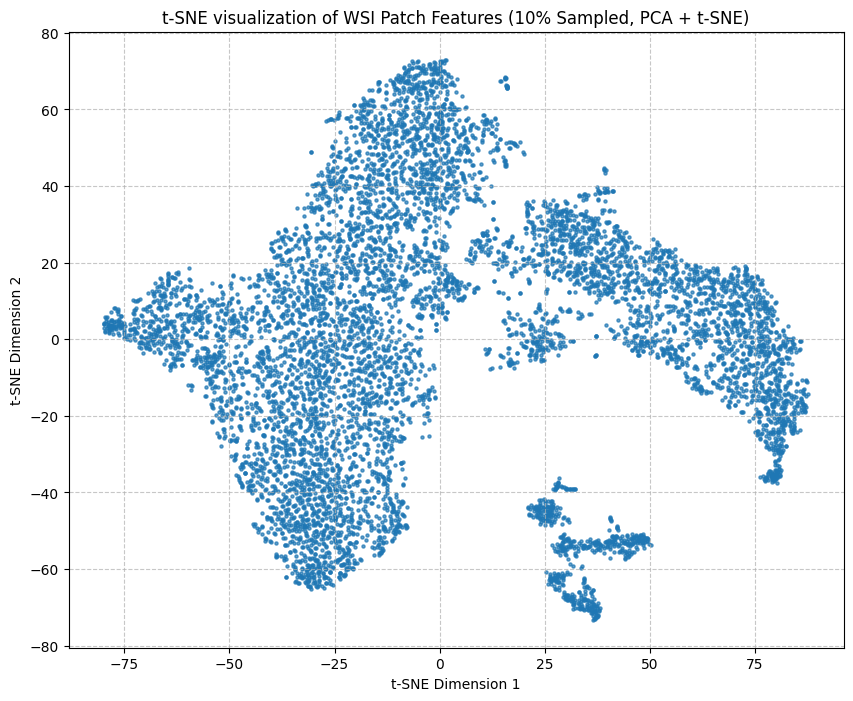

In [11]:
# --- 2. 设置采样百分比 ---
# 这是一个关键参数，你可以调整它来控制采样的数据量
sampling_percentage = 0.10 # 例如，采样 10% 的数据

# 计算采样数量
num_samples = features_np.shape[0]
num_sampled_features = int(num_samples * sampling_percentage)

print(f"\n--- 进行数据采样 (采样比例: {sampling_percentage*100:.0f}%) ---")
print(f"原始样本数量: {num_samples}")
print(f"采样样本数量: {num_sampled_features}")

# 随机选择样本的索引
np.random.seed(42) # 设置随机种子，确保结果可复现
sampled_indices = np.random.choice(num_samples, num_sampled_features, replace=False)

# 获取采样后的特征数据
sampled_features_np = features_np[sampled_indices]
print(f"采样后特征数据形状: {sampled_features_np.shape}")

# --- 3. PCA 降维 ---
print("\n--- 进行 PCA 降维 ---")
n_components_pca = 50 # 降维后的维度
pca = PCA(n_components=n_components_pca, random_state=42)

start_time_pca = time.time()
features_pca = pca.fit_transform(sampled_features_np) # 对采样后的数据进行 PCA
end_time_pca = time.time()

print(f"PCA 降维后数据形状: {features_pca.shape}")
print(f"PCA 降维耗时: {end_time_pca - start_time_pca:.2f} 秒")
print(f"PCA 解释的方差比例: {pca.explained_variance_ratio_.sum():.4f}")

# --- 4. t-SNE 可视化 ---
print("\n--- 进行 t-SNE 可视化 ---")
tsne = TSNE(n_components=2, perplexity=50, n_iter=2000, learning_rate=200,
            init='pca', random_state=42, n_jobs=-1)

start_time_tsne = time.time()
tsne_results = tsne.fit_transform(features_pca) # 对 PCA 后的数据进行 t-SNE
end_time_tsne = time.time()

print(f"t-SNE 降维后数据形状: {tsne_results.shape}")
print(f"t-SNE 计算耗时: {end_time_tsne - start_time_tsne:.2f} 秒")

# --- 5. 可视化结果 ---
print("\n--- 绘制 t-SNE 散点图 ---")
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=5, alpha=0.7) # 适当增大点的大小，因为样本少了
plt.title(f't-SNE visualization of WSI Patch Features ({sampling_percentage*100:.0f}% Sampled, PCA + t-SNE)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- 6. 如果有标签信息，可以这样可视化采样后的标签 ---
# 假设您有一个与原始 features_tensor 对应长度的标签列表或 NumPy 数组
# 例如：original_labels = np.random.randint(0, 5, size=80982) # 模拟 5 个类别

# 如果有标签，你需要获取采样后的标签：
# if 'original_labels' in locals():
#     sampled_labels = original_labels[sampled_indices]
#     print(f"采样后标签数据形状: {sampled_labels.shape}")

#     print("\n--- 绘制带标签的 t-SNE 散点图 (采样数据) ---")
#     plt.figure(figsize=(12, 10))
#     sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1],
#                     hue=sampled_labels, # 使用采样后的标签进行颜色编码
#                     palette=sns.color_palette("hsv", len(np.unique(sampled_labels))),
#                     legend="full",
#                     s=5, alpha=0.7)
#     plt.title(f't-SNE visualization of WSI Patch Features ({sampling_percentage*100:.0f}% Sampled, with Labels)')
#     plt.xlabel('t-SNE Dimension 1')
#     plt.ylabel('t-SNE Dimension 2')
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.show()

In [12]:
label_file = "/raid/mengliang/gabmil/files/tcga-brca_label.csv"

df_label = pd.read_csv(label_file)
df_label.head()

,filename,case_id,submitter_id,age,ethnicity,gender,race,primary_diagnosis,label
0,TCGA-A2-A25D-01Z-00-DX1.41DADDB8-3E3F-4F8F-8BE...,3b963d72-ba5c-467b-83c9-fbdb462510a3,TCGA-A2-A25D,89,not hispanic or latino,female,white,"Lobular carcinoma, NOS",ILC
1,TCGA-AR-A5QP-01Z-00-DX1.256FDB13-1F81-42DA-AF6...,3c275152-d04b-440c-9621-2fc05ea977b6,TCGA-AR-A5QP,54,not hispanic or latino,female,white,"Lobular carcinoma, NOS",ILC
2,TCGA-C8-A12P-01Z-00-DX1.670B5DE8-07B0-4E4C-93F...,abdc76db-f85e-4337-a57e-6d098789da03,TCGA-C8-A12P,55,not hispanic or latino,female,asian,"Infiltrating duct carcinoma, NOS",IDC
3,TCGA-E9-A1N8-01Z-00-DX1.1243AB1C-75A3-4A5E-967...,ac075bc0-1b59-4557-beea-541694faee03,TCGA-E9-A1N8,48,not hispanic or latino,female,white,"Infiltrating duct carcinoma, NOS",IDC
4,TCGA-A2-A0YF-01Z-00-DX1.6166E995-0669-43D6-B9C...,ae8c77fe-e6c8-44d5-8265-4a38c637bbef,TCGA-A2-A0YF,67,not hispanic or latino,female,black or african american,"Infiltrating duct carcinoma, NOS",IDC


In [ ]:
import pandas as pd
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import time

# --- Mock Data Generation (Replace with your actual data loading) ---
# Create a dummy CSV file
csv_filename = "/raid/mengliang/gabmil/files/tcga-brca_label.csv"
num_patients = 1000 # Let's start with 100 patients for quicker demonstration
genders = ['male', 'female']
oncotree_label = ["ILC", "IDC"]
# Create some dummy data for the CSV
data = {
    'filename': [os.path.join(feature_folder, f"pt_files/{i}.pt") for i in range(num_patients)],
    'gender': [random.choice(genders) for _ in range(num_patients)],
    'label': [random.choice(oncotree_label) for _ in range(num_patients)]
}
patients_df = pd.DataFrame(data)
patients_df.to_csv("files/tcga-brca_tsne", index=False)
print(f"Mock CSV '{csv_filename}' created.")

# Create dummy .pt files
feature_dim = 1024 # Dimension of each patch feature

# --- Actual Data Loading Starts Here ---
# Load the patient metadata from the CSV file
patients_df = pd.read_csv(csv_filename)
print(f"\nLoaded CSV with {len(patients_df)} patients.")

# Lists to store the sampled features and corresponding genders
sampled_patient_features = []
patient_genders = []
oncotree_labels = []

print("Sampling one feature per patient...")
for index, row in patients_df.iterrows():
    filename = row['filename']
    gender = row['gender']
    oncotree_label = row["label"]
    filepath = "/raid/mengliang/gabmil/tcga-brca_features/pt_files/" + filename + ".pt"

    if not os.path.exists(filepath):
        print(f"Warning: File not found for patient '{filename}'. Skipping.")
        continue

    try:
        # Load all features for the current patient
        all_patient_features = torch.load(filepath).cpu().numpy()

        # Randomly select one feature (patch) from this patient's data
        if all_patient_features.shape[0] > 0:
            random_idx = random.randint(0, all_patient_features.shape[0] - 1)
            sampled_feature = all_patient_features[random_idx]
            sampled_patient_features.append(sampled_feature)
            patient_genders.append(gender)
            oncotree_labels.append(oncotree_label)
        else:
            print(f"Warning: No features found in {filename}. Skipping.")

    except Exception as e:
        print(f"Error loading or sampling from {filename}: {e}. Skipping.")

# Convert lists to NumPy arrays for scikit-learn
sampled_patient_features_np = np.array(sampled_patient_features)
patient_genders_np = np.array(patient_genders)

print(f"Collected {sampled_patient_features_np.shape[0]} sampled features with dimensions {sampled_patient_features_np.shape[1]}.")

Mock CSV '/raid/mengliang/gabmil/files/tcga-brca_label.csv' created.

Loaded CSV with 1009 patients.
Sampling one feature per patient...


/tmp/ipykernel_2260885/3211313479.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_patient_features = torch.load(filepath).cpu().numpy()


In [22]:
print(sampled_features_np.shape)
print(sampled_patient_features_np.shape)
print(patient_genders_np.shape)

(8098, 1024)
(1000, 1024)
(1000,)



--- Performing PCA for dimensionality reduction ---
PCA reduced data shape: (1000, 50)
PCA execution time: 0.51 seconds
Total variance explained by PCA: 0.1669

--- Performing t-SNE visualization ---


/home/mxz3935/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE reduced data shape: (1000, 2)
t-SNE execution time: 4.79 seconds

--- Plotting t-SNE results by gender ---


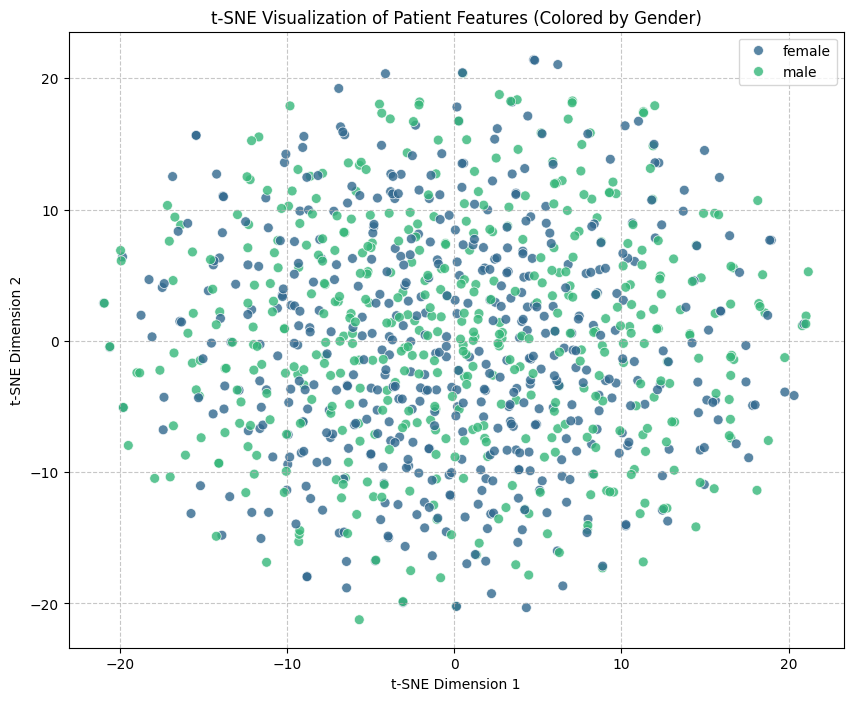

In [23]:
# --- PCA Dimensionality Reduction ---
print("\n--- Performing PCA for dimensionality reduction ---")
# Reduce to a reasonable number of components, e.g., 50
n_components_pca = 50
pca = PCA(n_components=n_components_pca, random_state=42)

start_time_pca = time.time()
features_pca = pca.fit_transform(sampled_patient_features_np)
end_time_pca = time.time()

print(f"PCA reduced data shape: {features_pca.shape}")
print(f"PCA execution time: {end_time_pca - start_time_pca:.2f} seconds")
print(f"Total variance explained by PCA: {pca.explained_variance_ratio_.sum():.4f}")

# --- t-SNE Visualization ---
print("\n--- Performing t-SNE visualization ---")
# t-SNE parameters - adjust perplexity based on your data size
# For 100-200 patients, perplexity 30-50 is usually fine.
tsne = TSNE(n_components=2, perplexity=30, n_iter=2500, learning_rate=200,
            init='pca', random_state=42, n_jobs=-1) # Use all CPU cores

start_time_tsne = time.time()
tsne_results = tsne.fit_transform(features_pca)
end_time_tsne = time.time()

print(f"t-SNE reduced data shape: {tsne_results.shape}")
print(f"t-SNE execution time: {end_time_tsne - start_time_tsne:.2f} seconds")

# --- Plotting the Results ---
print("\n--- Plotting t-SNE results by gender ---")
plt.figure(figsize=(10, 8))
# Use seaborn for better aesthetics and automatic coloring by 'hue' (gender)
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=patient_genders_np, # Color points based on gender
    palette='viridis', # Choose a color palette (e.g., 'viridis', 'plasma', 'Set1')
    legend='full',
    s=50, # Point size
    alpha=0.8 # Transparency
)
plt.title('t-SNE Visualization of Patient Features (Colored by Gender)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Clean up mock files (optional)
# for filename in patients_df['filename']:
#     os.remove(os.path.join('patient_features', filename))
# os.rmdir('patient_features')
# os.remove(csv_filename)
# print("Cleaned up mock files.")

Found 15 WSI feature files.
Total patches: 1500, Feature dim: (1500, 512)


/tmp/ipykernel_2812894/1840975832.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(feat_file, map_location="cpu")


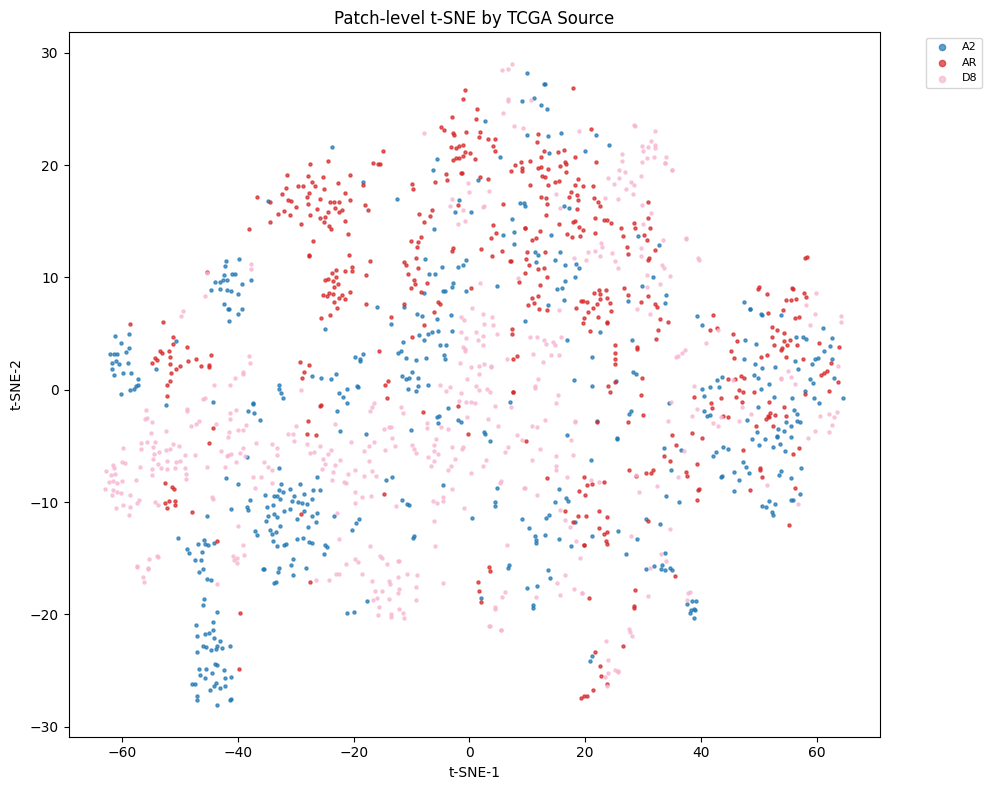

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from glob import glob

# 设置 feature 文件路径
feature_dir = "tcga-brca_patch_feature"  # 每个 WSI 的特征 .pt 文件目录

# 初始化容器
all_features = []
all_labels = []

# 遍历所有 .pt 文件（每个 WSI）
feature_files = sorted(glob(os.path.join(feature_dir, "*_features.pt")))
print(f"Found {len(feature_files)} WSI feature files.")


def extract_source(filename):
    # TCGA-XX-... -> XX
    parts = filename.split("-")
    return parts[1] if len(parts) >= 2 else "UNK"

# 遍历特征文件
for feat_file in feature_files:
    data = torch.load(feat_file, map_location="cpu")
    feats = data["features"]
    filename = data["filename"] if "filename" in data else os.path.basename(feat_file).split("_features")[0]
    source = extract_source(filename)

    all_features.append(feats)
    all_labels.extend([source] * feats.shape[0])  # 每个 patch 一个来源标签

# 聚合
all_features = torch.cat(all_features, dim=0).numpy()
print(f"Total patches: {len(all_labels)}, Feature dim: {all_features.shape}")

# 若数据过多，可以随机采样部分
from sklearn.utils import shuffle
all_features, all_labels = shuffle(all_features, all_labels, random_state=42)
max_points = 10000
all_features = all_features[:max_points]
all_labels = all_labels[:max_points]

# t-SNE 降维
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(all_features)

# 可视化
import matplotlib.cm as cm

unique_sources = sorted(set(all_labels))
label2color = {label: cm.tab20(i / len(unique_sources)) for i, label in enumerate(unique_sources)}

plt.figure(figsize=(10, 8))
for source in unique_sources:
    idx = [i for i, l in enumerate(all_labels) if l == source]
    plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=source, s=5, alpha=0.7, color=label2color[source])

plt.title("Patch-level t-SNE by TCGA Source")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

Loading .pt features:   0%|          | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_2816695/254823657.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(pt_path)


使用特征数量: 884
每个特征维度: 512


/tmp/ipykernel_2816695/254823657.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")


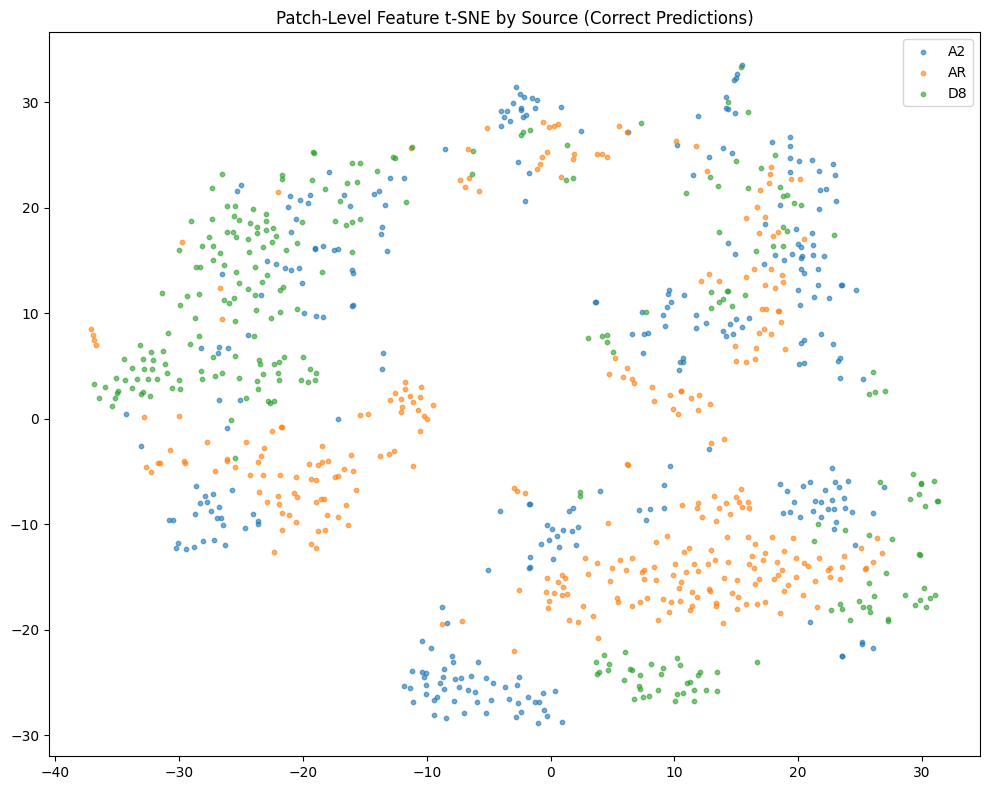

In [6]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.cm import get_cmap
from tqdm import tqdm


# === 路径设置 ===
df_path = "files/tcga-brca_patch_conch.csv"
feature_dir = "tcga-brca_patch_feature"
save_path = "tsne_patch_by_source.png"

# === 读取 patch-level df 并筛选 label == patch_label 的正确预测 ===
df = pd.read_csv(df_path)
df = df[df["label"] == df["patch_label"]].copy()

# 构建 npy_path → source 映射
npy2source = dict(zip(df["npy_path"], df["source"]))

# === 收集 patch 特征和 source ===
features = []
sources = []

for fname in tqdm(os.listdir(feature_dir), desc="Loading .pt features"):
    if not fname.endswith(".pt"):
        continue

    pt_path = os.path.join(feature_dir, fname)
    data = torch.load(pt_path)
    wsi_id = data["wsi_id"]
    wsi_id = os.path.splitext(wsi_id)[0]
    coords = data["coords"].numpy()   # [N, 2]
    feats = data["features"]          # [N, D]

    for i in range(len(coords)):
        x, y = coords[i]
        npy_path = f"tcga-brca_selected_patch/{wsi_id}/{x}_{y}.npy"

        if npy_path in npy2source:
            features.append(feats[i].cpu().numpy())
            sources.append(npy2source[npy_path])

features = np.stack(features)
sources = np.array(sources)

print("使用特征数量:", features.shape[0])
print("每个特征维度:", features.shape[1])

# === t-SNE 降维 ===
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeds = tsne.fit_transform(features)

# === 可视化 ===
plt.figure(figsize=(10, 8))
unique_sources = sorted(list(set(sources)))
cmap = get_cmap("tab10")
color_map = {src: cmap(i % 10) for i, src in enumerate(unique_sources)}

for src in unique_sources:
    idx = (sources == src)
    plt.scatter(embeds[idx, 0], embeds[idx, 1], 
                label=src, s=10, alpha=0.6, color=color_map[src])

plt.title("Patch-Level Feature t-SNE by Source (Correct Predictions)")
plt.legend()
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()


Loading .pt features:   0%|          | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_2816695/3901008049.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(pt_path)

使用 IDC 特征数量: 435
每个特征维度: 512


/tmp/ipykernel_2816695/3901008049.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")


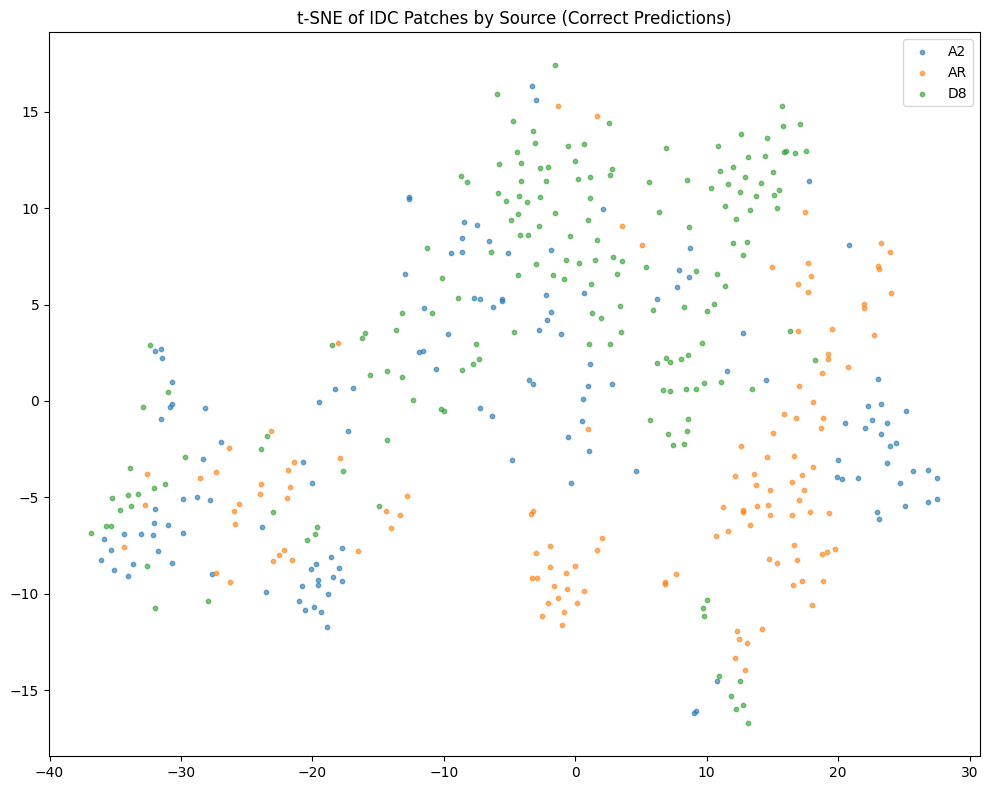

In [7]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.cm import get_cmap
from tqdm import tqdm

# === 路径设置 ===
df_path = "files/tcga-brca_patch_conch.csv"
feature_dir = "tcga-brca_patch_feature"
save_path = "tsne_patch_idc_by_source.png"

# === 读取 patch-level df 并筛选 label == patch_label == IDC 的正确预测 ===
df = pd.read_csv(df_path)
df = df[(df["label"] == "IDC") & (df["patch_label"] == "IDC")].copy()

# 构建 npy_path → source 映射
npy2source = dict(zip(df["npy_path"], df["source"]))

# === 收集 patch 特征和 source ===
features = []
sources = []

for fname in tqdm(os.listdir(feature_dir), desc="Loading .pt features"):
    if not fname.endswith(".pt"):
        continue

    pt_path = os.path.join(feature_dir, fname)
    data = torch.load(pt_path)
    wsi_id = data["wsi_id"]
    wsi_id = os.path.splitext(wsi_id)[0]
    coords = data["coords"].numpy()
    feats = data["features"]

    for i in range(len(coords)):
        x, y = coords[i]
        npy_path = f"tcga-brca_selected_patch/{wsi_id}/{x}_{y}.npy"

        if npy_path in npy2source:
            features.append(feats[i].cpu().numpy())
            sources.append(npy2source[npy_path])

features = np.stack(features)
sources = np.array(sources)

print("使用 IDC 特征数量:", features.shape[0])
print("每个特征维度:", features.shape[1])

# === t-SNE 降维 ===
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeds = tsne.fit_transform(features)

# === 可视化 ===
plt.figure(figsize=(10, 8))
unique_sources = sorted(list(set(sources)))
cmap = get_cmap("tab10")
color_map = {src: cmap(i % 10) for i, src in enumerate(unique_sources)}

for src in unique_sources:
    idx = (sources == src)
    plt.scatter(embeds[idx, 0], embeds[idx, 1],
                label=src, s=10, alpha=0.6, color=color_map[src])

plt.title("t-SNE of IDC Patches by Source (Correct Predictions)")
plt.legend()
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()